**Chapter 13 – Convolution Neural Networks**

Inspired from tensorflow 2.0 tutorial from https://www.tensorflow.org/tutorials/images/cnn

# Approach 1

Take dataset for MNIST and a-z alphabets (from Kaggle), combine them and train the model using CNN

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import csv
from PIL import Image
import numpy as np
import string
import os
# import random
from sklearn.utils import shuffle

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
PROJECT_ROOT_DIR = "."
csv_File_Path = os.path.join(PROJECT_ROOT_DIR, "datasets", 'handwritten_letters', "A_Z Handwritten Data.csv")

count = 1
last_digit_Name =  None

image_Folder_Path = os.path.join(PROJECT_ROOT_DIR, "datasets", 'handwritten_letters')

Alphabet_Mapping_List = list(string.ascii_uppercase)

for alphabet in Alphabet_Mapping_List:
    path = image_Folder_Path + '\\' + alphabet
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
tf.keras.backend.set_floatx('float64')
def change_type(l, dtype=float):
    return np.asarray(list(map(dtype, l)))

In [4]:
with open(csv_File_Path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    count = 0
    image_array = []
    label_array = []
    complete_dateset = []
    for row in reader:
#         if count%25000 == 0 and count < 125001:
        label = int(row.pop(0))
        image = change_type(np.asarray(row))
        label_array.append(label)
        image_array.append(image)
        count += 1
    
    print('Length of Label Array: ' + str(len(label_array)))
    print('Length of Image Array: ' + str(len(image_array)))
    print('count: ' + str(count)) 

Length of Label Array: 372451
Length of Image Array: 372451
count: 372451


In [5]:
print(label_array[0:10])
print(image_array[0][0])
# print(image_array[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.0


In [6]:
X = image_array
y = label_array
X, y = shuffle(X, y, random_state=0)
print(y[0:5])

[14, 20, 4, 18, 17]


In order to combine both mnist and a-z dataset, labels for a-z dataset are added 10, because mnist will take 1-10 label spots

In [7]:
X2 = []
for index in range(len(X)):
    X2.append(X[index].reshape(28, 28))
    y[index] += 10

In [8]:
X3 = np.asarray(X2)
X3.shape

(372451, 28, 28)

In [9]:
X3 = X3/255.

In [10]:
y[0:5]

[24, 30, 14, 28, 27]

In [11]:
az_image_train, az_image_test, az_label_train, az_label_test = X3[:322000], X3[322000:], y[:322000], y[322000:]

In [12]:
mnist = tf.keras.datasets.mnist

In [13]:
(mnist_image_train, mnist_label_train), (mnist_image_test, mnist_label_test) = mnist.load_data()
mnist_image_train, mnist_image_test = mnist_image_train / 255.0, mnist_image_test / 255.0

In [14]:
print('az_image_train.shape: ' + str(az_image_train.shape))
print('az_image_train[0].shape: ' + str(az_image_train[0].shape))

az_image_train.shape: (322000, 28, 28)
az_image_train[0].shape: (28, 28)


In [15]:
print('mnist_image_train.shape: ' + str(mnist_image_train.shape))
print('mnist_image_train[0].shape: ' + str(mnist_image_train[0].shape))

mnist_image_train.shape: (60000, 28, 28)
mnist_image_train[0].shape: (28, 28)


### Verify the Image dataset

In [16]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
               'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
               'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def plot_images(image_dataset, label_dataset):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_dataset[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[label_dataset[i]])
    plt.show()

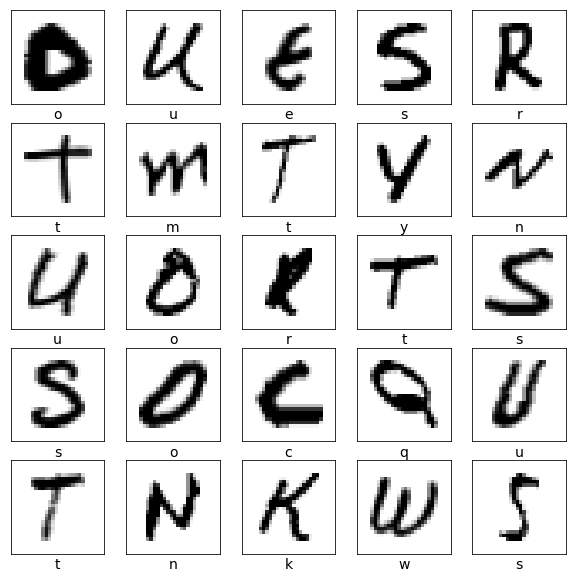

In [17]:
plot_images(az_image_train, az_label_train)

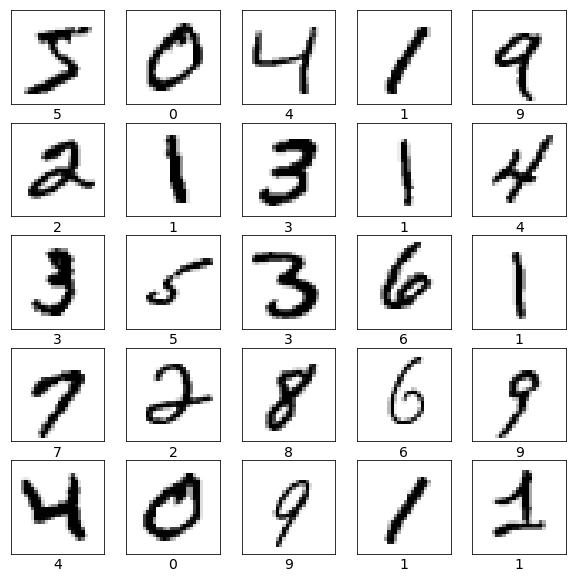

In [18]:
plot_images(mnist_image_train, mnist_label_train)

#### Separate training and test datasets of MNIST and a-z dataset have been created, now both the training and both test sets for images and labels for MNIST and a-z datasets needs to be merged respectively and shuffled.

In [19]:
print(az_image_train.shape)
print(mnist_image_train.shape)
train_image = np.concatenate((mnist_image_train, az_image_train), axis=0)
print(train_image.shape)

(322000, 28, 28)
(60000, 28, 28)
(382000, 28, 28)


In [21]:
print('az_label_train: ' + str(len(az_label_train)))
print('mnist_label_train: ' + str(len(mnist_label_train)))
train_label = np.concatenate((mnist_label_train, az_label_train), axis=0)
print(train_label.shape)

az_label_train: 322000
mnist_label_train: 60000
(382000,)


In [22]:
train_image, train_label = shuffle(train_image, train_label, random_state=0)

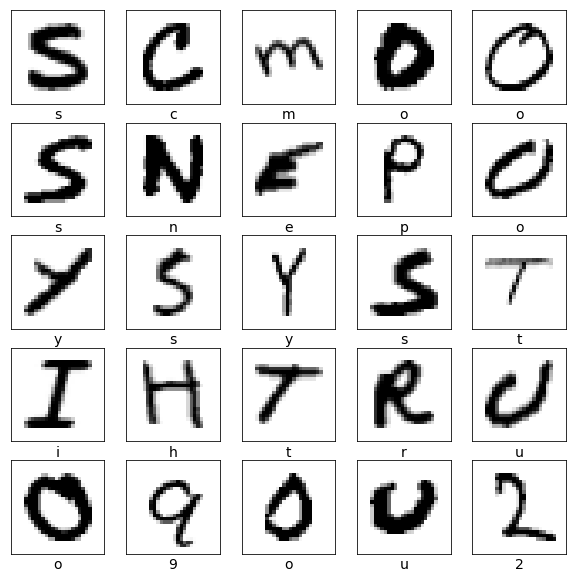

In [23]:
plot_images(train_image, train_label)

In [24]:
print(az_image_test.shape)
print(mnist_image_test.shape)
test_image = np.concatenate((mnist_image_test, az_image_test), axis=0)
print(test_image.shape)

(50451, 28, 28)
(10000, 28, 28)
(60451, 28, 28)


In [26]:
print('az_label_test: ' + str(len(az_label_test)))
print('mnist_label_test: ' + str(len(mnist_label_test)))
test_label = np.concatenate((mnist_label_test, az_label_test), axis=0)
print(test_label.shape)

az_label_test: 50451
mnist_label_test: 10000
(60451,)


In [27]:
test_image, test_label = shuffle(test_image, test_label, random_state=0)

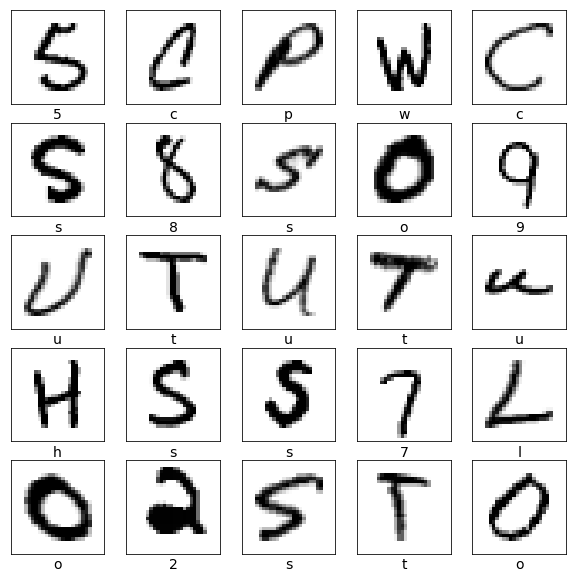

In [28]:
plot_images(test_image, test_label)

In [29]:
train_label[0:25]

array([28, 12, 22, 24, 24, 28, 23, 14, 25, 24, 34, 28, 34, 28, 29, 18, 17,
       29, 27, 30, 24,  9, 24, 30,  2])

In [30]:
test_label[0:25]

array([ 5, 12, 25, 32, 12, 28,  8, 28, 24,  9, 30, 29, 30, 29, 30, 17, 28,
       28,  7, 21, 24,  2, 28, 29, 24])

## Convolution Base

In [31]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28,28)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(36, activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                4644      
Total params: 105,124
Trainable params: 105,124
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the model

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
# previously executed, not executing again to save time.
history = model.fit(train_image, train_label, epochs=10, 
                    validation_data=(test_image, test_label))

Train on 382000 samples, validate on 60451 samples
Epoch 1/10
382000/382000 [==============================] - 48s 125us/sample - loss: 2.9451 - accuracy: 0.6905 - val_loss: 2.8386 - val_accuracy: 0.7948
Epoch 2/10
382000/382000 [==============================] - 46s 120us/sample - loss: 2.8257 - accuracy: 0.8079 - val_loss: 2.8087 - val_accuracy: 0.8230
Epoch 3/10
382000/382000 [==============================] - 43s 113us/sample - loss: 2.8110 - accuracy: 0.8212 - val_loss: 2.8046 - val_accuracy: 0.8264
Epoch 4/10
382000/382000 [==============================] - 46s 119us/sample - loss: 2.8062 - accuracy: 0.8253 - val_loss: 2.7998 - val_accuracy: 0.8310
Epoch 5/10
382000/382000 [==============================] - 45s 118us/sample - loss: 2.8037 - accuracy: 0.8274 - val_loss: 2.7999 - val_accuracy: 0.8305
Epoch 6/10
382000/382000 [==============================] - 46s 120us/sample - loss: 2.8018 - accuracy: 0.8291 - val_loss: 2.7979 - val_accuracy: 0.8326
Epoch 7/10
382000/382000 [=====

## Evaluate Model

In [93]:
# previously executed, not executing again to save time.
test_loss, test_acc = model.evaluate(test_image, test_label, verbose=2)

60451/1 - 3s - loss: 2.8793 - accuracy: 0.8351


In [94]:
# previously executed, not executing again to save time.
print('test_loss: ' + str(test_loss))
print('test_acc: ' + str(test_acc))

test_loss: 2.795060150372996
test_acc: 0.8351061190054755


## New Model with Convolution and MaxPooling 1D

In [95]:
# previously executed, not executing again to save time.
new_model = models.Sequential()

### Add Conv1D and MaxPooling Layers

In [96]:
# previously executed, not executing again to save time.
new_model.add(layers.Conv1D(28, (1, ), activation='relu', input_shape=(28, 28)))
new_model.add(layers.MaxPooling1D(pool_size=2))

In [97]:
# previously executed, not executing again to save time.
new_model.add(layers.Flatten(input_shape=(28,3)))
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.Dense(36, activation='softmax'))

In [98]:
# previously executed, not executing again to save time.
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 28)            812       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 28)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               50304     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 36)                4644      
Total params: 55,760
Trainable params: 55,760
Non-trainable params: 0
__________________________________________________

## Compile and Train

In [99]:
# previously executed, not executing again to save time.
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
# previously executed, not executing again to save time.
history = new_model.fit(train_image, train_label, epochs=10, 
                    validation_data=(test_image, test_label))

Train on 382000 samples, validate on 60451 samples
Epoch 1/10
382000/382000 [==============================] - 52s 137us/sample - loss: 2.9875 - accuracy: 0.6460 - val_loss: 2.9061 - val_accuracy: 0.7251
Epoch 2/10
382000/382000 [==============================] - 50s 130us/sample - loss: 2.8869 - accuracy: 0.7446 - val_loss: 2.8775 - val_accuracy: 0.7535
Epoch 3/10
382000/382000 [==============================] - 48s 127us/sample - loss: 2.8701 - accuracy: 0.7608 - val_loss: 2.8607 - val_accuracy: 0.7698
Epoch 4/10
382000/382000 [==============================] - 48s 127us/sample - loss: 2.8626 - accuracy: 0.7680 - val_loss: 2.8583 - val_accuracy: 0.7720
Epoch 5/10
382000/382000 [==============================] - 54s 142us/sample - loss: 2.8539 - accuracy: 0.7765 - val_loss: 2.8358 - val_accuracy: 0.7944
Epoch 6/10
382000/382000 [==============================] - 53s 140us/sample - loss: 2.8363 - accuracy: 0.7941 - val_loss: 2.8317 - val_accuracy: 0.7985
Epoch 7/10
382000/382000 [=====

## Evaluate

In [101]:
# previously executed, not executing again to save time.
test_loss, test_acc = new_model.evaluate(test_image, test_label, verbose=2)

60451/1 - 3s - loss: 2.8822 - accuracy: 0.8290


In [102]:
# previously executed, not executing again to save time.
print('test_loss: ' + str(test_loss))
print('test_acc: ' + str(test_acc))

test_loss: 2.800959508584014
test_acc: 0.8289689169740782


In [103]:
# previously executed, not executing again to save time.
model3 = models.Sequential()

### Add Conv1D and MaxPooling Layers

In [105]:
# previously executed, not executing again to save time.
model3.add(layers.Conv1D(32, 3, activation='relu', input_shape=(28, 28)))
model3.add(layers.Flatten(input_shape=(28,3)))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(36, activation='softmax'))

In [106]:
# previously executed, not executing again to save time.
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 26, 32)            2720      
_________________________________________________________________
flatten_6 (Flatten)          (None, 832)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               106624    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 36)                4644      
Total params: 113,988
Trainable params: 113,988
Non-trainable params: 0
_________________________________________________________________


## Compile and Train

In [107]:
# previously executed, not executing again to save time.
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [108]:
# previously executed, not executing again to save time.
history = model3.fit(train_image, train_label, epochs=10, 
                    validation_data=(test_image, test_label))

Train on 382000 samples, validate on 60451 samples
Epoch 1/10
382000/382000 [==============================] - 64s 166us/sample - loss: 2.9262 - accuracy: 0.7066 - val_loss: 2.8136 - val_accuracy: 0.8182
Epoch 2/10
382000/382000 [==============================] - 64s 168us/sample - loss: 2.7979 - accuracy: 0.8336 - val_loss: 2.7843 - val_accuracy: 0.8465
Epoch 3/10
382000/382000 [==============================] - 64s 167us/sample - loss: 2.7858 - accuracy: 0.8449 - val_loss: 2.7821 - val_accuracy: 0.8483
Epoch 4/10
382000/382000 [==============================] - 65s 171us/sample - loss: 2.7822 - accuracy: 0.8481 - val_loss: 2.7830 - val_accuracy: 0.8472
Epoch 5/10
382000/382000 [==============================] - 76s 199us/sample - loss: 2.7769 - accuracy: 0.8534 - val_loss: 2.7665 - val_accuracy: 0.8638
Epoch 6/10
382000/382000 [==============================] - 76s 200us/sample - loss: 2.7652 - accuracy: 0.8650 - val_loss: 2.7621 - val_accuracy: 0.8680
Epoch 7/10
382000/382000 [=====

## Evaluate

In [109]:
# previously executed, not executing again to save time.
test_loss, test_acc = model3.evaluate(test_image, test_label, verbose=2)

60451/1 - 3s - loss: 2.8623 - accuracy: 0.8689


In [110]:
# previously executed, not executing again to save time.
print('test_loss: ' + str(test_loss))
print('test_acc: ' + str(test_acc))

test_loss: 2.761131040440728
test_acc: 0.8689020859869977


## Define Custom Model for better accuracy

In [34]:
X_train = train_image[..., tf.newaxis]
X_test = test_image[..., tf.newaxis]

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_label)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, test_label)).batch(32)

In [36]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(36, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model4 = MyModel()

In [37]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [39]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model4(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model4.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model4.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [40]:
@tf.function
def test_step(images, labels):
  predictions = model4(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [41]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

Epoch 1, Loss: 0.18032924923051133, Accuracy: 94.93350785340314, Test Loss: 0.10723373549842527, Test Accuracy: 96.98102595490563
Epoch 2, Loss: 0.07456355799684301, Accuracy: 97.79869109947644, Test Loss: 0.079600797394933, Test Accuracy: 97.78663711104862
Epoch 3, Loss: 0.041975275189632164, Accuracy: 98.71335078534031, Test Loss: 0.07763114674203545, Test Accuracy: 98.00995847876793
Epoch 4, Loss: 0.02812082688409127, Accuracy: 99.09607329842932, Test Loss: 0.07804589570354264, Test Accuracy: 98.16876478470165
Epoch 5, Loss: 0.020718017017613822, Accuracy: 99.31937172774869, Test Loss: 0.08751856508632493, Test Accuracy: 98.25478486708244


In [46]:
def test_prediction_image(image, prediction, probab, label):
    plt.subplot(5,5,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    lbl = 'L: ' + label + ', Pred: ' + str(prediction) + ', P: ' + str(round(probab, 2))
    plt.xlabel(lbl)
    plt.show()

In [43]:
t_ds = tf.data.Dataset.from_tensor_slices((X_test, test_label)).batch(10)

In [47]:
def test_model(model):
    index = 0
    for test_images, test_labels in t_ds:
#         print('labels:' + str(test_labels))
        if index < 2:
            predictions = model(test_images)
            length = len(predictions)
            for p_index in range(length):
                count = index * 10
                test_prediction_image(test_image[count + p_index], 
                                      class_names[np.argmax(predictions[p_index])], 
                                      np.amax(predictions[p_index]),
                                      class_names[test_label[count + p_index]])
            index += 1
        else:
            break

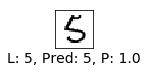

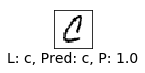

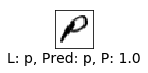

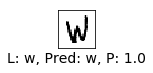

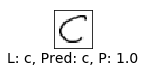

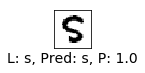

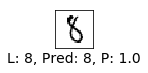

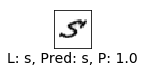

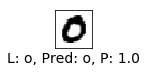

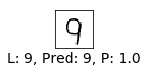

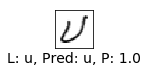

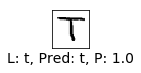

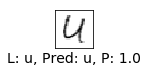

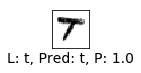

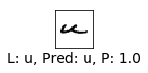

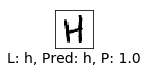

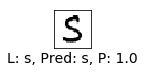

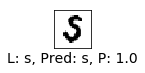

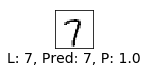

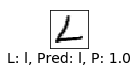

In [48]:
test_model(model4)

## Save the Learnings

In [77]:
path = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN', "epoch5_v1_04-apr-2020")
model.save(path, save_format='tf')
# model.save_weights(checkpoint_path.format(epoch=1))

INFO:tensorflow:Assets written to: .\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v1_04-apr-2020\assets


In [78]:
new_model = tf.keras.models.load_model(path)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                4644      
Total params: 105,124
Trainable params: 105,124
Non-trainable params: 0
_________________________________________________________________


In [79]:
model4.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2769024   
_________________________________________________________________
dense_3 (Dense)              multiple                  4644      
Total params: 2,773,988
Trainable params: 2,773,988
Non-trainable params: 0
_________________________________________________________________


In [100]:
path = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN', "epoch5_v4_04-apr-2020")
model.save_weights(path)

In [101]:
latest = tf.train.latest_checkpoint(os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN'))
print(latest)

.\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v4_04-apr-2020


In [102]:
new_model = MyModel()
new_model.load_weights(latest)

AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tensorflow.python.keras.layers.core.Dense object at 0x00000298510D3128>, <tensorflow.python.keras.layers.core.Flatten object at 0x00000298510D1B38>, <tensorflow.python.keras.layers.core.Dense object at 0x00000298510D3D30>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000298510CEB38>]

In [110]:
ckpt_dir = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN') 
file_name = 'epoch5_v6_04-apr-2020'
full_path = os.path.join(ckpt_dir, file_name)
print(full_path)
model.save_weights(full_path)

.\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v6_04-apr-2020


In [113]:
new_model = MyModel()
new_model.load_weights(full_path)

AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000029850EA9DA0>, <tensorflow.python.keras.layers.core.Dense object at 0x0000029850EA9E48>, <tensorflow.python.keras.layers.core.Dense object at 0x0000029850EA5B70>, <tensorflow.python.keras.layers.core.Flatten object at 0x0000029850EA9A58>]

In [114]:
new_model = MyModel()
new_model.load_weights(full_path, by_name=True)

NotImplementedError: Weights may only be loaded based on topology into Models when loading TensorFlow-formatted weights (got by_name=True to load_weights).

In [97]:
new_model = MyModel()
new_model.load_weights(latest)

AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tensorflow.python.keras.layers.core.Dense object at 0x00000298510D3F60>, <tensorflow.python.keras.layers.core.Flatten object at 0x00000298510D6128>, <tensorflow.python.keras.layers.core.Dense object at 0x00000298510CE9E8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000298510CF550>]

In [91]:
model5 = model4
model5.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2769024   
_________________________________________________________________
dense_3 (Dense)              multiple                  4644      
Total params: 2,773,988
Trainable params: 2,773,988
Non-trainable params: 0
_________________________________________________________________


In [92]:
ckpt_dir = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN') 
file_name = 'epoch5_v5_04-apr-2020.tf'
full_path = os.path.join(ckpt_dir, file_name)
print(full_path)

.\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v5_04-apr-2020.tf


In [93]:
model5.reset_metrics()
model5.save(full_path)

INFO:tensorflow:Assets written to: .\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v5_04-apr-2020.tf\assets


In [95]:
from tensorflow import keras
from tensorflow.keras import layers
new_model = keras.models.load_model(full_path)

In [96]:
new_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


ValueError: You tried to call `count_params` on conv2d, but the layer isn't built. You can build it manually via: `conv2d.build(batch_input_shape)`.

In [115]:
ckpt_dir = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN')
file_name = 'epoch5_v6_04-apr-2020'
full_path = os.path.join(ckpt_dir, file_name)
print(full_path)

.\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v6_04-apr-2020


In [116]:
tf.saved_model.save(model4, full_path)

INFO:tensorflow:Assets written to: .\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v6_04-apr-2020\assets


In [126]:
loaded = tf.saved_model.load(full_path)
print(list(loaded.signatures.keys()))
loaded

['serving_default']


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x29853bdc940>

In [127]:
model4

In [128]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)
infer

{'output_1': TensorSpec(shape=(None, 36), dtype=tf.float64, name='output_1')}


In [130]:
loaded.summary()

AttributeError: '_UserObject' object has no attribute 'summary'

In [133]:
ckpt_dir = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN')
file_name = 'epoch5_v7_05-apr-2020'
full_path = os.path.join(ckpt_dir, file_name)

# path = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '13_a_z_tf_2.0_CNN', "e3_v2")
# checkpoint_path = os.path.join(PROJECT_ROOT_DIR, "Checkpoints", '10_a_ztf_2.0', "e3_w_v1", "cp-{epoch:04d}.ckpt")
# model.save(path, save_format='tf')
# model.save_weights(checkpoint_path.format(epoch=1))
print('path: ' + path)
print('full_path: ' + full_path)

path: .\Checkpoints\10_a_ztf_2.0\e3_v2
full_path: .\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v7_05-apr-2020


In [140]:
model4.save(full_path, save_format='tf')

INFO:tensorflow:Assets written to: .\Checkpoints\13_a_z_tf_2.0_CNN\epoch5_v7_05-apr-2020\assets


In [141]:
new_model = tf.keras.models.load_model(path)
input_shape = (32, 3)
new_model.conv1.build(input_shape)
new_model.flatten.build(input_shape)
new_model.d1.build(input_shape)
new_model.d2.build(input_shape)

In [142]:
new_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2769024   
_________________________________________________________________
dense_3 (Dense)              multiple                  4644      
Total params: 2,773,988
Trainable params: 2,773,988
Non-trainable params: 0
_________________________________________________________________


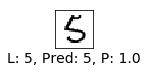

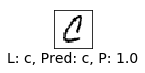

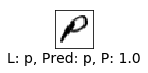

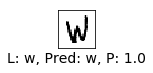

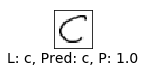

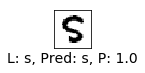

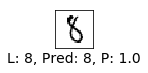

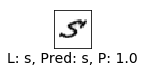

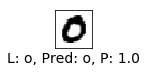

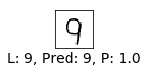

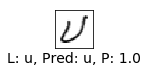

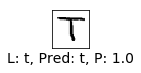

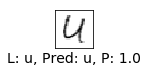

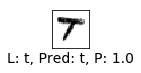

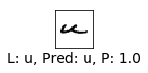

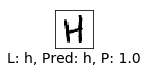

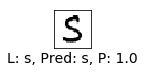

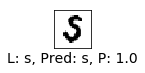

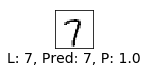

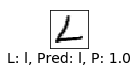

In [143]:
test_model(new_model)